In [1]:
import pandas as pd

import sys
sys.path.append("./modules/") # for d3plus2
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
# from HH_tools import *
import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

from IPython.display import display, HTML

In [2]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!

path = './data/disagg_struct_refs/sources/US/'
# agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['total_annual_wages', 'Wages'],
                                 ['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [3]:
# variable = 'annual_avg_emplvl'
variable = 'annual_avg_estabs'
X = df_cnt.unstack()[variable]
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

#### Other Variables

# Population
county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)
county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

# Wages
df_indu = df_cnt.groupby(level = 0).sum()
avg_wages_city = df_indu[['total_annual_wages']].div(df_indu[['annual_avg_emplvl']].values).dropna()
avg_wages_city = avg_wages_city.rename(columns= {'total_annual_wages': 'avg_annual_wages'})
# avg_wages_city = np.log10(avg_wages_city)
avg_wages_city.index = avg_wages_city.index.astype(str).str.zfill(5)

# Area
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

In [4]:
X_vars = pd.concat([county_pop.loc[X.index], avg_wages_city.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X = pd.concat([X_vars, X], axis = 1, sort = True)


/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [25]:
fillzero = .1
X_ = X.T.fillna(X.min(1)).T.replace(0, fillzero)
C = np.log10(X_).corr()

def cosine_similarity(table):
    norms = np.linalg.norm(table, axis = 0)
    norm = np.outer(norms, norms)
    result = table.T.dot(table).div(norm)
    return result

C = cosine_similarity(X.fillna(0))

In [26]:
import scipy.linalg as la

avals, avecs = la.eig(C.values)
avals = np.real(avals) # == np.abs(avals)

In [18]:
# vals = np.log10(X_).values#[:3, :3]

# # # Apply Null
# # np.random.shuffle(vals) # counties are mixed up but industries info is kept
# # # np.sum(null, axis = 0)  # axis = 0 means industry sums. Check they are kept equal. 

# corr = pd.DataFrame(vals).corr()

# display(corr.iloc[:4, :4])

# avals, avecs = la.eig(corr.values)
# avals = np.real(avals) # == np.abs(avals)
# # plt.hist(avals, range(int(round(max(avals))) + 1))

# # avecs.T - avecs # != 0, i.e. not symmetric
# # np.round(avecs.T - np.linalg.inv(avecs), -13) # = 0. Its orthogonal

# avals[:10]

In [19]:
# plt.plot(avals) # the eigenvector has a value for each industry.
# plt.show()

(array([294.,  13.,   3.,   3.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

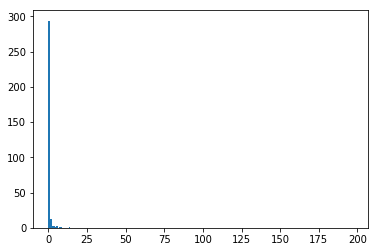

In [8]:
plt.hist(avals, range(int(round(max(avals))) + 1))
# Tiene un aval muy alto y los demas abajo. Esto esta OK. Va con la idea que hay una dependencia que todas las series tienen.

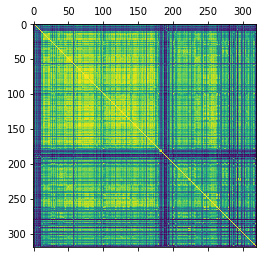

In [27]:
# Because C is real, symmetric, we can express it as sum of eigenvals times matrix prod of eigenvecs.
def component(k, avals = avals, avecs = avecs):
    uk = np.array(len(avals)*[avecs.T[k]]).reshape(avecs.shape) # la componente k agarra el elemento k de todos los autovectores.
    return np.real(avals[k]*np.multiply(uk.T, uk))

C_s = component(0) # structural component
C_r = np.array([component(i) for i in range(1, len(avals))]).sum(axis=0) # random component

plt.matshow(C_s + C_r, vmin = 0, vmax = 1)


In [21]:
# np.array([component(i) for i in range(1, len(avals))]).sum(axis=0)

In [339]:
U.dot(L.dot(U.T).dot(x))

array([[1.00000000e+00+0.j],
       [8.93586348e-01+0.j],
       [7.83039183e-01+0.j],
       [3.34484263e-01+0.j],
       [1.03695543e-01+0.j],
       [7.89627033e-02+0.j],
       [2.45412251e-01+0.j],
       [1.19135405e-01+0.j],
       [1.89058898e-01+0.j],
       [1.90044500e-01+0.j],
       [1.30659714e-01+0.j],
       [3.13086227e-01+0.j],
       [3.63372947e-01+0.j],
       [3.05056050e-01+0.j],
       [3.37288242e-01+0.j],
       [4.48497192e-01+0.j],
       [3.49106791e-01+0.j],
       [3.84465893e-01+0.j],
       [3.65591646e-01+0.j],
       [3.57374475e-01+0.j],
       [2.93332422e-01+0.j],
       [4.95330716e-01+0.j],
       [4.74314918e-01+0.j],
       [4.75779604e-01+0.j],
       [5.30792931e-01+0.j],
       [2.82650912e-01+0.j],
       [2.49876367e-01+0.j],
       [2.41791926e-01+0.j],
       [3.44556516e-01+0.j],
       [4.02687177e-01+0.j],
       [2.68416961e-01+0.j],
       [2.45452006e-01+0.j],
       [4.78748802e-01+0.j],
       [1.89594787e-01+0.j],
       [4.5118

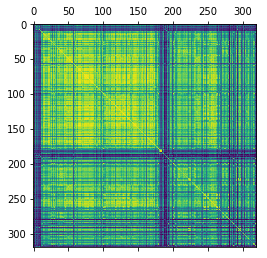

In [28]:
C_s = component(0) # structural component
C_g = np.array([component(i) for i in range(1, 20)]).sum(axis=0) # random component
C_r = np.array([component(i) for i in range(20, len(avals))]).sum(axis=0) # random component

plt.matshow(C_s + C_g, vmin = 0, vmax = 1)

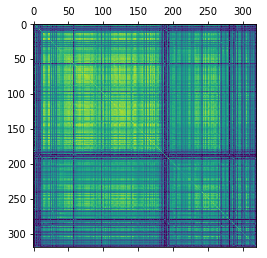

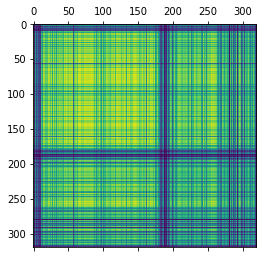

In [29]:
plt.matshow(C_s, vmin = 0, vmax = 1)

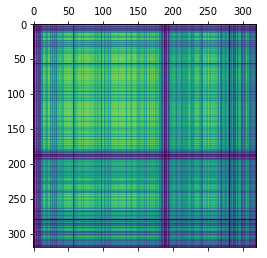

In [23]:
plt.matshow(C_s, vmin = 0, vmax = 1)

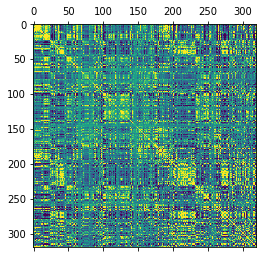

In [30]:
plt.matshow(C_g, vmin = -.1, vmax = .1)

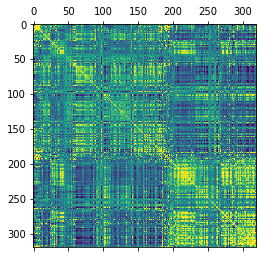

In [12]:
plt.matshow(C_g, vmin = -.1, vmax = .1)

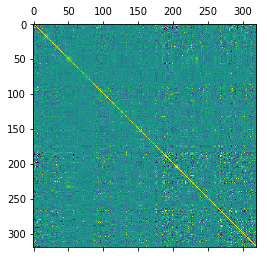

In [31]:
plt.matshow(np.real(C_r), vmin = -.05, vmax = .05)

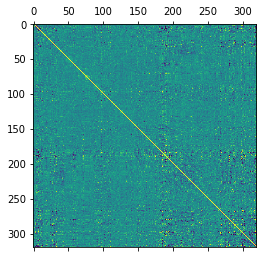

In [13]:
plt.matshow(np.real(C_r), vmin = -.05, vmax = .05)

In [24]:
C_g

array([[ 0.73809316,  0.81586992,  0.75593251, ..., -0.04989516,
        -0.16933812,  0.00759936],
       [ 0.81586992,  0.93075966,  0.87540089, ..., -0.02801491,
        -0.14528635,  0.0172427 ],
       [ 0.75593251,  0.87540089,  0.91816553, ...,  0.03947772,
        -0.11365608,  0.09357046],
       ...,
       [-0.04989516, -0.02801491,  0.03947772, ...,  0.4167694 ,
         0.07538551,  0.06600496],
       [-0.16933812, -0.14528635, -0.11365608, ...,  0.07538551,
         0.24284109,  0.06807846],
       [ 0.00759936,  0.0172427 ,  0.09357046, ...,  0.06600496,
         0.06807846,  0.35206171]])

In [15]:
C_g

array([[ 0.73809316,  0.81586992,  0.75593251, ..., -0.04989516,
        -0.16933812,  0.00759936],
       [ 0.81586992,  0.93075966,  0.87540089, ..., -0.02801491,
        -0.14528635,  0.0172427 ],
       [ 0.75593251,  0.87540089,  0.91816553, ...,  0.03947772,
        -0.11365608,  0.09357046],
       ...,
       [-0.04989516, -0.02801491,  0.03947772, ...,  0.4167694 ,
         0.07538551,  0.06600496],
       [-0.16933812, -0.14528635, -0.11365608, ...,  0.07538551,
         0.24284109,  0.06807846],
       [ 0.00759936,  0.0172427 ,  0.09357046, ...,  0.06600496,
         0.06807846,  0.35206171]])

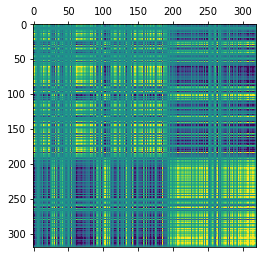

In [410]:
plt.matshow(np.real(component(1)), vmin = -.08, vmax = .08)

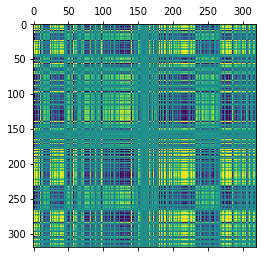

In [411]:
plt.matshow(np.real(component(2)), vmin = -.04, vmax = .04)

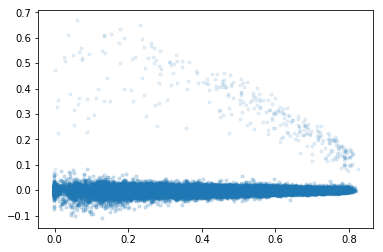

In [449]:
plt.plot(np.real(C_s).flatten(), np.real(C_r).flatten(), lw = 0, marker = '.', alpha = .1)

In [432]:
df = pd.DataFrame(np.real(component(6)), index = X.columns, columns=X.columns)
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_corr_vals = df.stack()[~keep]

pares = pd.DataFrame(undirected_corr_vals, columns = ['corr'])
pares = pares.reset_index().merge(industry_titles, left_on = 'level_0', right_on = 'industry_code').merge(industry_titles, left_on = 'level_1', right_on = 'industry_code')
pares = pares.sort_values('corr')

pares.head(10).drop(['industry_code_x', 'industry_code_y'], axis = 1)

,level_0,level_1,corr,industry_title_x,industry_title_y
319,1119,ALAND,-0.145390,NAICS 1119 Other crop farming,Area
2,1119,POPESTIMATE2010,-0.127384,NAICS 1119 Other crop farming,Population
607,1113,ALAND,-0.120324,NAICS 1113 Fruit and tree nut farming,Area
505,1131,ALAND,-0.118362,NAICS 1131 Timber tract operations,Area
325,1153,ALAND,-0.109061,NAICS 1153 Support activities for forestry,Area
323,1133,ALAND,-0.106642,NAICS 1133 Logging,Area
290,1113,POPESTIMATE2010,-0.105422,NAICS 1113 Fruit and tree nut farming,Population
322,1132,ALAND,-0.103711,NAICS 1132 Forest nursery and gathering forest...,Area
188,1131,POPESTIMATE2010,-0.103703,NAICS 1131 Timber tract operations,Population
1112,7224,1119,-0.103386,"NAICS 7224 Drinking places, alcoholic beverages",NAICS 1119 Other crop farming


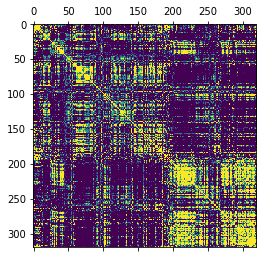

In [389]:
plt.matshow(np.real(C_r), vmin = 0, vmax = .05)
